In [13]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/LSML/final')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!pip install transformers

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bz2
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import re
import seaborn as sns
import torch
from transformers import RobertaForSequenceClassification, RobertaTokenizer, AdamW
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
import random
from sklearn.metrics import accuracy_score

%matplotlib inline

## Reading the data

In [4]:
def get_labels_and_texts(file):
    labels = []
    texts = []
    for line in bz2.BZ2File(file):
        x = line.decode("utf-8")
        labels.append(int(x[9]) - 1)
        texts.append(x[10:].strip())
    return np.array(labels), texts
train_labels, train_texts = get_labels_and_texts('./train.ft.txt.bz2')
test_labels, test_texts = get_labels_and_texts('./test.ft.txt.bz2')

In [8]:
train_dict = {'review': train_texts[:1000000], 'labels': train_labels[:1000000]}
train = pd.DataFrame(train_dict)
test_dict = {'review': test_texts, 'labels': test_labels}
test = pd.DataFrame(test_dict)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


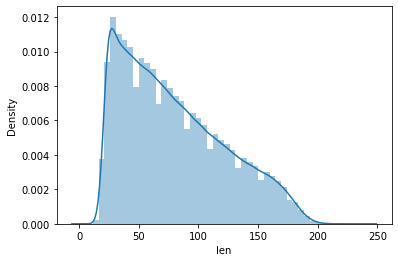

In [33]:
train['len'] = train['review'].apply(lambda x: len(x.split()))
sns.distplot(train['len'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Labels distribution')

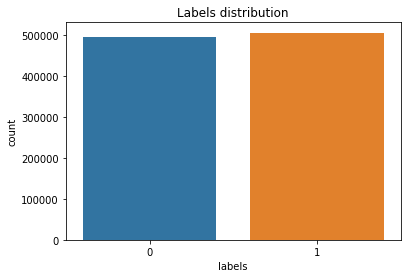

In [6]:
sns.countplot(train['labels'])
plt.title('Labels distribution')

## Preprocess and Prepare Dataset

In [7]:
X, y = train.drop(['labels'], axis=1), train.labels
X_test, y_test = test.drop(['labels'], axis=1), test.labels
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
review_train = X_train.review.values
labels_train = y_train.values

review_dev = X_dev.review.values
labels_dev = y_dev.values

review_test = X_test.review.values
labels_test = y_test.values

In [45]:
def encode_data(tokenizer, reviews, max_length):
    """Encode the question/passage pairs into features than can be fed to the model."""
    input_ids = []
    attention_masks = []

    for num, review in enumerate(reviews):
        if num % 100000 == 0:
          print(num)
        encoded_data = tokenizer(review, max_length=max_length, pad_to_max_length=True) #pad_to_max_length=True) #, pad_to_max_length=True, add_special_tokens=True)
        encoded_pair = encoded_data["input_ids"]
        attention_mask = encoded_data["attention_mask"]

        input_ids.append(encoded_pair)
        attention_masks.append(attention_mask)

    return np.array(input_ids), np.array(attention_masks)

In [10]:
len(review_train), len(review_dev), len(review_test)

(800000, 200000, 200000)

In [11]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

tokenizer = RobertaTokenizer.from_pretrained("roberta-base") 

cuda


Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [47]:
max_seq_length = 128

input_ids_train, attention_masks_train = encode_data(tokenizer, review_train, max_seq_length)
input_ids_dev, attention_masks_dev = encode_data(tokenizer, review_dev, max_seq_length)
input_ids_test, attention_masks_test = encode_data(tokenizer, review_test, max_seq_length)

train_features = (input_ids_train, attention_masks_train, labels_train)
dev_features = (input_ids_dev, attention_masks_dev, labels_dev)
test_features = (input_ids_test, attention_masks_test, labels_test)
# input_ids_train

0


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


100000
200000
300000
400000
500000
600000
700000
0
100000
0
100000


In [ ]:
# free_gpu_cache() 

In [61]:
batch_size = 32

train_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in train_features]
dev_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in dev_features]
test_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in test_features]

# free_gpu_cache() 

train_dataset = TensorDataset(*train_features_tensors)
dev_dataset = TensorDataset(*dev_features_tensors)
test_dataset = TensorDataset(*test_features_tensors)

# free_gpu_cache() 

train_sampler = RandomSampler(train_dataset)
dev_sampler = SequentialSampler(dev_dataset)
test_sampler = SequentialSampler(test_dataset)

# free_gpu_cache() 

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, sampler=dev_sampler, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

In [ ]:
# free_gpu_cache() 

In [56]:
from tqdm import tqdm

In [57]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base')
model.to(device) 

learning_rate = 1e-5
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [65]:
epochs = 2
grad_acc_steps = 4
train_loss_values = []
dev_acc_values = []

for _ in tqdm(range(epochs), desc="Epoch"):

  # Training
  epoch_train_loss = 0 
  model.train()
  model.zero_grad()

  for step, batch in enumerate(train_dataloader):
      if step % 1000 == 0:
        print('train step #', step, 'of 25000')
      # CUDA_LAUNCH_BLOCKING=1
      # print(batch[0].shape)
      input_ids = batch[0].to(device)
      
      attention_masks = batch[1].to(device)
      labels = batch[2].to(device)     

      outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks, labels=labels)

      loss = outputs[0]
      loss = loss / grad_acc_steps
      epoch_train_loss += loss.item()

      loss.backward()
      
      if (step+1) % grad_acc_steps == 0: 
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
        optimizer.step()
        model.zero_grad()

  epoch_train_loss = epoch_train_loss / len(train_dataloader)          
  train_loss_values.append(epoch_train_loss)
  
  # Evaluation
  epoch_dev_accuracy = 0 
  model.eval()

  for step, batch in enumerate(dev_dataloader):
    if step % 1000 == 0:
        print('dev step #', step, 'of 6250')
    input_ids = batch[0].to(device)
    attention_masks = batch[1].to(device)
    labels = batch[2]
                
    with torch.no_grad():        
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
                    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    
    predictions = np.argmax(logits, axis=1).flatten()
    labels = labels.numpy().flatten()
    
    epoch_dev_accuracy += np.sum(predictions == labels) / len(labels)

  epoch_dev_accuracy = epoch_dev_accuracy / len(dev_dataloader)
  print("  Accuracy: {0:.2f}".format(epoch_dev_accuracy))
  dev_acc_values.append(epoch_dev_accuracy)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

train step # 0 of 25000
train step # 1000 of 25000
train step # 2000 of 25000
train step # 3000 of 25000
train step # 4000 of 25000
train step # 5000 of 25000
train step # 6000 of 25000
train step # 7000 of 25000
train step # 8000 of 25000
train step # 9000 of 25000
train step # 10000 of 25000
train step # 11000 of 25000
train step # 12000 of 25000
train step # 13000 of 25000
train step # 14000 of 25000
train step # 15000 of 25000
train step # 16000 of 25000
train step # 17000 of 25000
train step # 18000 of 25000
train step # 19000 of 25000
train step # 20000 of 25000
train step # 21000 of 25000
train step # 22000 of 25000
train step # 23000 of 25000
train step # 24000 of 25000
dev step # 0 of 6250
dev step # 1000 of 6250
dev step # 2000 of 6250
dev step # 3000 of 6250
dev step # 4000 of 6250
dev step # 5000 of 6250
dev step # 6000 of 6250


Epoch:  50%|█████     | 1/2 [2:45:37<2:45:37, 9937.84s/it]

  Accuracy: 0.97
train step # 0 of 25000
train step # 1000 of 25000
train step # 2000 of 25000
train step # 3000 of 25000
train step # 4000 of 25000
train step # 5000 of 25000
train step # 6000 of 25000
train step # 7000 of 25000
train step # 8000 of 25000
train step # 9000 of 25000
train step # 10000 of 25000
train step # 11000 of 25000
train step # 12000 of 25000
train step # 13000 of 25000
train step # 14000 of 25000
train step # 15000 of 25000
train step # 16000 of 25000
train step # 17000 of 25000
train step # 18000 of 25000
train step # 19000 of 25000
train step # 20000 of 25000
train step # 21000 of 25000
train step # 22000 of 25000
train step # 23000 of 25000
train step # 24000 of 25000
dev step # 0 of 6250
dev step # 1000 of 6250
dev step # 2000 of 6250
dev step # 3000 of 6250
dev step # 4000 of 6250
dev step # 5000 of 6250
dev step # 6000 of 6250


Epoch: 100%|██████████| 2/2 [5:31:16<00:00, 9938.36s/it]

  Accuracy: 0.97


## Save model

In [66]:
torch.save(model.state_dict(), './model_bert.pth')

## Restore model

In [10]:
model_rest = RobertaForSequenceClassification.from_pretrained('roberta-base')
model_rest = model_rest.to(device) 
model_rest.load_state_dict(torch.load('./model_bert.pth'))

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

<All keys matched successfully>

In [21]:
def predict(review):
  sequence = tokenizer(review, return_tensors="pt", max_length=512, truncation=True)['input_ids'].to(device)
  
  logits = model_rest(sequence)[0]

  probabilities = torch.softmax(logits, dim=1).detach().cpu().tolist()[0]

  proba_pos = round(probabilities[1], 2)
  proba_neg = round(probabilities[0], 2)
  if proba_pos > proba_neg:
    return 1
  else:
    return 0


In [22]:
test['answer'] = test['review'].apply(predict)

In [23]:
accuracy_score(list(test['labels']), list(test['answer']))

0.97157